# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 32.5 s, sys: 13.7 s, total: 46.2 s
Wall time: 49.6 s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 7.97 s, sys: 596 ms, total: 8.57 s
Wall time: 4.49 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 22 s, sys: 852 ms, total: 22.8 s
Wall time: 12.5 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 37.9 s, sys: 953 ms, total: 38.9 s
Wall time: 20.2 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.9].index)
drop2 = list(null2[null2 > 0.9].index)
drop3 = list(null3[null3 > 0.9].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1180 905 785


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 532 922 1147 features
We will train with 23562 users info


# Train CatBoost models

In [27]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [28]:
cat_params = {
        'iterations': 1000,
        'early_stopping_rounds': 90,
        'depth': 5,
        'learning_rate': 0.02,
        'loss_function': "Logloss",
        'random_seed': 42,
        'metric_period': 1,
        'subsample': 0.8,
        'colsample_bylevel': 0.4,
        'verbose': 0,
        'l2_leaf_reg': 20,
    }

In [29]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with532features
#########################


,mean
feature,
tunic.capitol_0.hall_ET_sum_,1.997792
tunic.capitol_0.hall_ET_max_,1.778434
4_ET_sum_,1.754205
3tunic.historicalsociety.collection_level_room_count,1.684099
chap1_finale_c_ET_sum_,1.630696
checkpoint_ET_mean_,1.524901
basic_name_counts,1.493846
checkpoint_ET_sum_,1.434299
chap1_finale_c_ET_max_,1.386318


#########################
question2, with532features
#########################


,mean
feature,
tunic.historicalsociety.collection.gramps.found_ET_min_,3.375686
object_click_event_name_counts,2.357927
tunic.capitol_0.hall_ET_max_,1.997693
chap1_finale_c_ET_max_,1.773102
chap1_finale_c_ET_sum_,1.522885
checkpoint_ET_mean_,1.487720
checkpoint_ET_sum_,1.453509
basic_name_counts,1.415188
tunic.capitol_0.hall_ET_sum_,1.289907


#########################
question3, with532features
#########################


,mean
feature,
basic_name_counts,3.007146
object_click_event_name_counts,2.237209
tunic.capitol_0.hall_ET_sum_,2.084427
tunic.capitol_0.hall_ET_max_,2.020118
checkpoint_ET_min_,1.893567
basic_ET_max_,1.891090
chap1_finale_c_ET_max_,1.850903
checkpoint_ET_sum_,1.789587
chap1_finale_c_ET_sum_,1.590765


#########################
question4, with922features
#########################


,mean
feature,
tunic.library.frontdesk.worker.wells_ET_sum_,1.630576
tunic.library.frontdesk.worker.wells_ET_mean_,1.602981
session_number_,1.583278
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.398225
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.340287
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_mean_,1.284133
tunic.historicalsociety.frontdesk_room_fqid_counts,1.163490
5-12_LEVEL_group_count,1.113398
tunic.library.frontdesk.worker.hello_ET_mean_,1.062577


#########################
question5, with922features
#########################


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_mean_,2.146269
5-12_LEVEL_group_count,2.131177
session_number_,1.974269
11_LEVEL_count,1.651617
basic_name_counts,1.377586
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.234684
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.165309
tunic.humanecology.frontdesk.worker.intro_ET_min_,0.963083
observation_click_ET_max_,0.894421


#########################
question6, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,2.201701
session_number_,1.521778
11_LEVEL_count,1.268670
basic_name_counts,0.856189
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.820927
trigger_scarf_ET_std_,0.787267
businesscards_ET_max_,0.777651
hover_duration_mean_,0.760864
logbook.page.bingo_ET_mean_,0.742332


#########################
question7, with922features
#########################


,mean
feature,
hover_duration_mean_,1.669263
session_number_,1.408244
journals.pic_1.next_ET_min_,1.115586
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.992032
5-12_LEVEL_group_count,0.985993
10_ET_std_,0.983669
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.900506
tunic.historicalsociety.frontdesk_room_fqid_counts,0.846263
logbook.page.bingo_ET_max_,0.832318


#########################
question8, with922features
#########################


,mean
feature,
object_click_event_name_counts,1.482553
session_number_,0.995075
11_LEVEL_count,0.938543
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.910950
basic_name_counts,0.908409
5-12_LEVEL_group_count,0.875593
tunic.historicalsociety.frontdesk_room_fqid_counts,0.773057
text_fqid_unique_,0.710897
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.629136


#########################
question9, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.779913
session_number_,1.469301
11_LEVEL_count,1.363687
basic_name_counts,1.087645
journals.pic_1.next_ET_min_,1.028733
reader_fqid_counts,0.984825
observation_click_ET_mean_,0.905037
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.849147
reader.paper1.next_ET_min_,0.837603


#########################
question10, with922features
#########################


,mean
feature,
basic_name_counts,1.774655
11_LEVEL_count,1.642255
5-12_LEVEL_group_count,1.625389
session_number_,1.003283
tunic.historicalsociety.stacks_ET_sum_,0.984403
journals_ET_sum_,0.855026
tunic.historicalsociety.closet_dirty.gramps.news_ET_mean_,0.836219
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.781256
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.759855


#########################
question11, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.710329
basic_name_counts,1.181524
session_number_,1.119499
11_LEVEL_count,1.028560
room_coor_y_mean_,0.970784
tostacks_ET_sum_,0.751775
navigate_click_event_name_counts,0.701373
tunic.historicalsociety.frontdesk_room_fqid_counts,0.699253
tunic.historicalsociety.closet_dirty.gramps.news_ET_min_,0.687671


#########################
question12, with922features
#########################


,mean
feature,
session_number_,1.482424
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.162278
hover_duration_mean_,1.120681
tunic.historicalsociety.frontdesk_room_fqid_counts,0.975600
12tunic.historicalsociety.frontdesk_level_room_count,0.831134
5-12_LEVEL_group_count,0.793288
businesscards.card_0.next_ET_mean_,0.759881
12_ET_sum_,0.742985
screen_coor_y_sum_,0.714205


#########################
question13, with922features
#########################


,mean
feature,
object_click_event_name_counts,2.479459
object_click_ET_sum_,1.324868
journals_bingo_duration,1.172762
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,0.991740
businesscards_fqid_counts,0.888624
reader_bingo_duration,0.800653
11tunic.historicalsociety.stacks_level_room_count,0.729965
close_ET_mean_,0.696605
journals.pic_2.bingo_ET_min_,0.652050


#########################
question14, with1147features
#########################


,mean
feature,
20_LEVEL_count,1.396672
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,1.111975
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.915991
tracks_ET_sum_,0.776234
tunic.wildlife.center.crane_ranger.crane_ET_std_,0.703456
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.674329
crane_ranger_ET_std_,0.627421
tunic.historicalsociety.entry.groupconvo_flag_ET_min_,0.618946
tunic.historicalsociety.entry.boss.flag_ET_min_,0.575910


#########################
question15, with1147features
#########################


,mean
feature,
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,1.119972
13-22_LEVEL_group_count,1.012177
tunic.historicalsociety.entry.boss.flag_ET_min_,0.950066
tunic.flaghouse.entry.colorbook_ET_min_,0.902231
map_click_event_name_counts,0.858498
tracks_ET_sum_,0.819366
tunic.historicalsociety.entry.boss.flag_ET_mean_,0.808295
tunic.historicalsociety.entry.groupconvo_flag_ET_sum_,0.637399
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.604704


#########################
question16, with1147features
#########################


,mean
feature,
19tunic.wildlife.center_level_room_count,0.825858
colorbook_ET_mean_,0.770899
journals_flag_ET_sum_,0.657380
tunic.flaghouse.entry.colorbook_ET_max_,0.605995
tunic.flaghouse.entry_ET_max_,0.574077
directory.closeup.archivist_ET_std_,0.570350
tunic.flaghouse.entry.colorbook_ET_min_,0.558337
tunic.library.frontdesk.worker.nelson_ET_sum_,0.524935
tunic.flaghouse.entry.colorbook_ET_mean_,0.499195


#########################
question17, with1147features
#########################


,mean
feature,
journals_flag.pic_0.next_ET_sum_,1.267207
19_ET_sum_,0.838703
journals_flag.pic_0.next_ET_max_,0.737224
journals_flag_ET_sum_,0.667618
journals_ET_mean_,0.626266
notification_click_ET_std_,0.526738
journals_flag.hub.topics_ET_max_,0.490163
tunic.library.frontdesk_ET_sum_,0.489666
21_ET_sum_,0.472436


#########################
question18, with1147features
#########################


,mean
feature,
close_ET_sum_,1.333400
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,1.073170
tunic.historicalsociety.entry.boss.flag_ET_min_,0.913573
20_ET_sum_,0.822725
flag_girl_fqid_counts,0.817065
journals_flag.pic_2.next_ET_sum_,0.733561
20_LEVEL_count,0.707412
notebook_click_ET_sum_,0.662023
tunic.historicalsociety.entry.groupconvo_flag_ET_mean_,0.628510


In [30]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [31]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

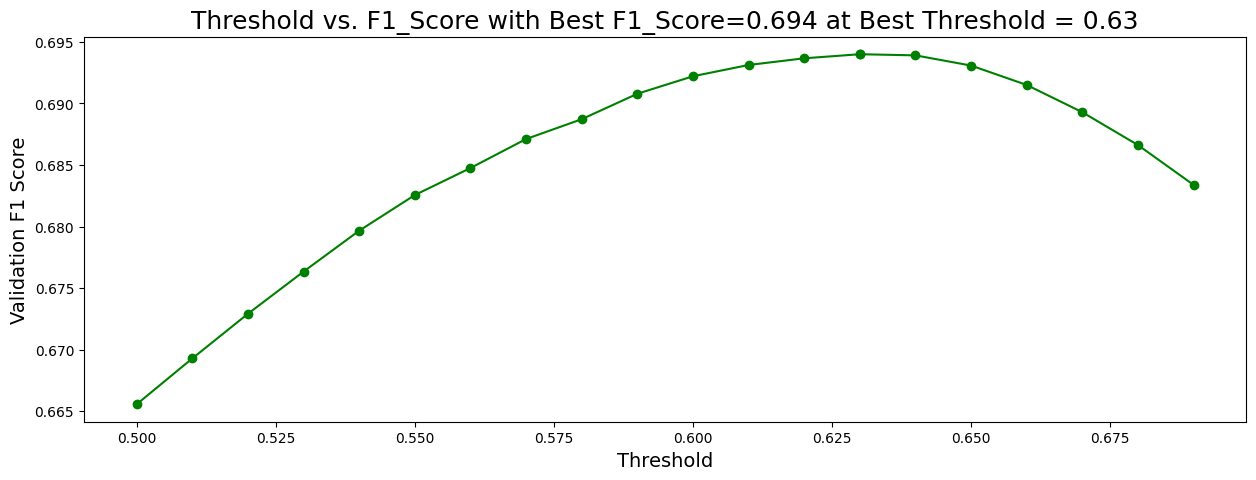

When using optimal threshold = 0.63...
Q0: F1 = 0.6687295720212715
Q1: F1 = 0.5024847394543819
Q2: F1 = 0.5084239694348164
Q3: F1 = 0.6681389872801461
Q4: F1 = 0.6202562287635034
Q5: F1 = 0.6416692431849444
Q6: F1 = 0.6237760082021355
Q7: F1 = 0.5566846292149814
Q8: F1 = 0.6272946480122072
Q9: F1 = 0.5656828832923855
Q10: F1 = 0.6063466796339863
Q11: F1 = 0.5119662391026709
Q12: F1 = 0.45825971580631225
Q13: F1 = 0.6344220210557572
Q14: F1 = 0.588524845008073
Q15: F1 = 0.4940374474555239
Q16: F1 = 0.5529765849398283
Q17: F1 = 0.48979258666167275
==> Overall F1 = 0.6940005731708457
s


In [32]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

In [33]:
import pickle
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

# Submission Jo Wilder

In [34]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [35]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [36]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 0
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [37]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("-MEAN: ",np.mean(sub1["correct"]))
sub1.head(109)

Shape:  (54, 2)
Shape:  (54, 2)
-MEAN:  0.6296296


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,0.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0
